# MNIST: Sensitivity on Kernel Density Estimation Parameters for Log-Linear Model

In [1]:
import os
os.environ["PYTHONWARNINGS"] = "ignore"

import warnings
warnings.filterwarnings('ignore')

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from sklearn.neighbors import KernelDensity

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from PIL import Image

from joblib import Parallel, delayed

import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import ld

In [2]:
def renormalize_image(image, threshold=False, threshold_value=10):
    """
    Renormalize an image such that pixel values are between 0 and 255.
    Optionally, set small pixel values to 0.

    Parameters:
    - image: numpy array with shape (28, 28)
    - threshold: bool, if True, set small pixel values to 0
    - threshold_value: int, the value below which pixels are set to 0 (if threshold is True)

    Returns:
    - renormalized_image: numpy array with shape (28, 28), pixel values between 0 and 255
    """
    # Ensure the image is a numpy array
    image = np.array(image)

    # Renormalize pixel values to be between 0 and 255
    min_val = np.min(image)
    max_val = np.max(image)
    renormalized_image = 255 * (image - min_val) / (max_val - min_val)

    # Apply threshold if needed
    if threshold:
        renormalized_image[renormalized_image < threshold_value] = 0

    return renormalized_image.astype(np.uint8)

def vectorize_tensor(T, B):
    """
    Vectorizes the tensor T by selecting only the indices in B.

    Parameters:
    - T: numpy array of shape (num_samples, ...)
    - B: list of indices to select from each sample

    Returns:
    - V: vectorized representation of T of shape (num_samples, len(B))
    """
    num_samples = T.shape[0]
    V = np.zeros((num_samples, len(B)))
    for i in range(num_samples):
        for j, idx in enumerate(B):
            V[i, j] = T[i, *idx]
    return V

def reconstruct_tensor(V, T_shape, B):
    """
    Reconstructs the tensor T from its vectorized representation V.

    Parameters:
    - V: vectorized representation of T of shape (num_samples, len(B))
    - T_shape: original shape of the tensor T
    - B: list of indices that were used to create the vectorized representation

    Returns:
    - T: reconstructed tensor with the original shape, missing values filled with zero
    """
    num_samples = V.shape[0]
    T = np.zeros(T_shape)
    for i in range(num_samples):
        for j, idx in enumerate(B):
            T[i, *idx] = V[i, j]
    return T

## Setup

### Dataset

In [3]:
D = 28*28
S = (7, 2, 2, 7, 2, 2)
train_size = 100
plot_num = 20
paper_plot_num = 1
k = 8
eps = np.asarray(1.0e-5)

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', download=True, train=True, transform=transform)

save_dir = './data/MNIST_images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    # Save images by class
    for class_label in range(10):
        class_dir = os.path.join(save_dir, str(class_label))
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        basis = np.where(train_dataset.targets.numpy() == class_label)[0]
        for i, idx in enumerate(basis):
            img, _ = train_dataset[idx]
            img = transforms.ToPILImage()(img)
            img.save(os.path.join(class_dir, f'{i}.png'))

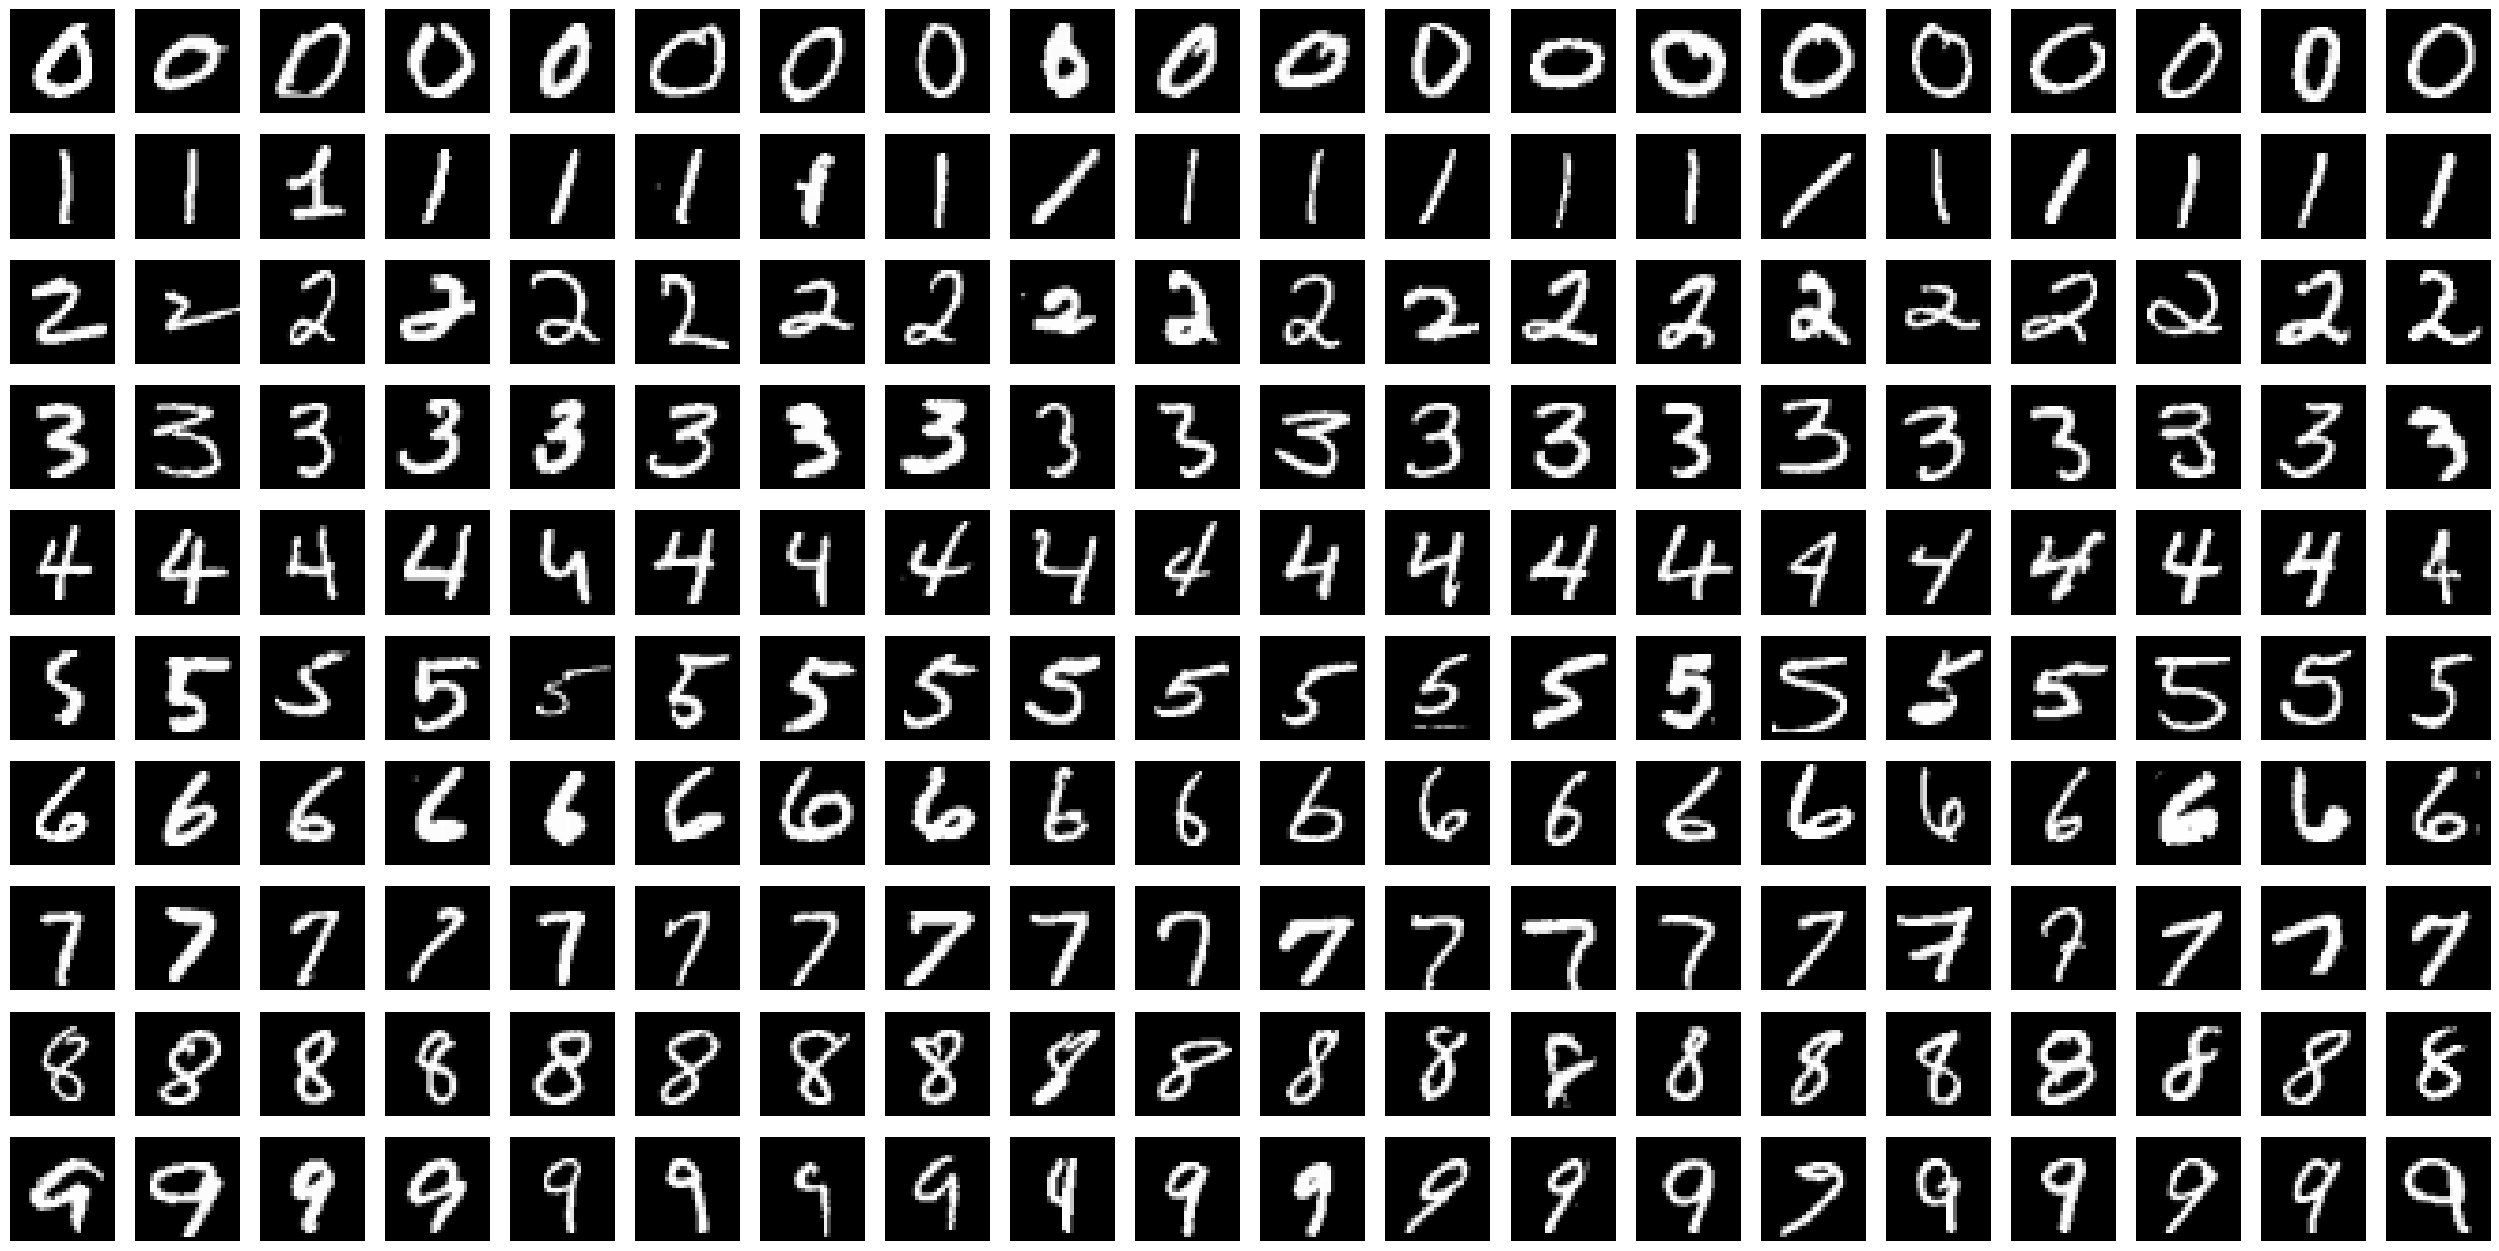

In [5]:
# Function to load images from a directory
def load_images_from_folder(folder, max_images=20):
    images = []
    for filename in os.listdir(folder)[:max_images]:
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

P_digit = []
original_data = []

for digit in range(10):
    class_folder = os.path.join(save_dir, str(digit))
    images = load_images_from_folder(class_folder, max_images=train_size)

    P = []
    for i in range(len(images)):
        img = images[i]
        img = img.resize((28, 28))
        original_data.append(np.asarray(img))
        array_obj = np.asarray(img).reshape(S)
        P.append(array_obj)

    P_digit.append(np.array(P))

# Load and display images horizontally for each class
plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(P_digit[digit][i].reshape((28,28)), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.show()

## Data Augmentation with Log-Linear Model

### Legendre Decomposition (Many-Body Approximation)

In [6]:
B_LD = ld.default_B(S, 2, cp.get_array_module(P[0]))

print(B_LD.shape)

def helper(i, digit):
    _, _, scaleX, Q, theta = ld.LD(P_digit[digit][i], B=B_LD, verbose=False, n_iter=1000, lr=1e-1)
    return (scaleX, Q, theta)

results = Parallel(n_jobs=30)(delayed(helper)(i, digit) for i in range(train_size) for digit in range(10))

scaleX_digit = []
Q_digit = []
theta_digit = []
X_recons_digit = []

for digit in range(10):
    scaleX_list = []
    Q_list = []
    theta_list = []
    X_recons_list = []
    for i in range(train_size):
        result = results[i*10 + digit]

        scaleX_list.append(result[0])
        Q_list.append(result[1])
        theta_list.append(result[2])
        X_recons = (result[1] * result[0]).astype(np.int32)
        X_recons_list.append(X_recons)

    scaleX_digit.append(np.array(scaleX_list))
    Q_digit.append(np.array(Q_list))
    theta_digit.append(np.array(theta_list))
    X_recons_digit.append(np.array(X_recons_list))

(107, 6)


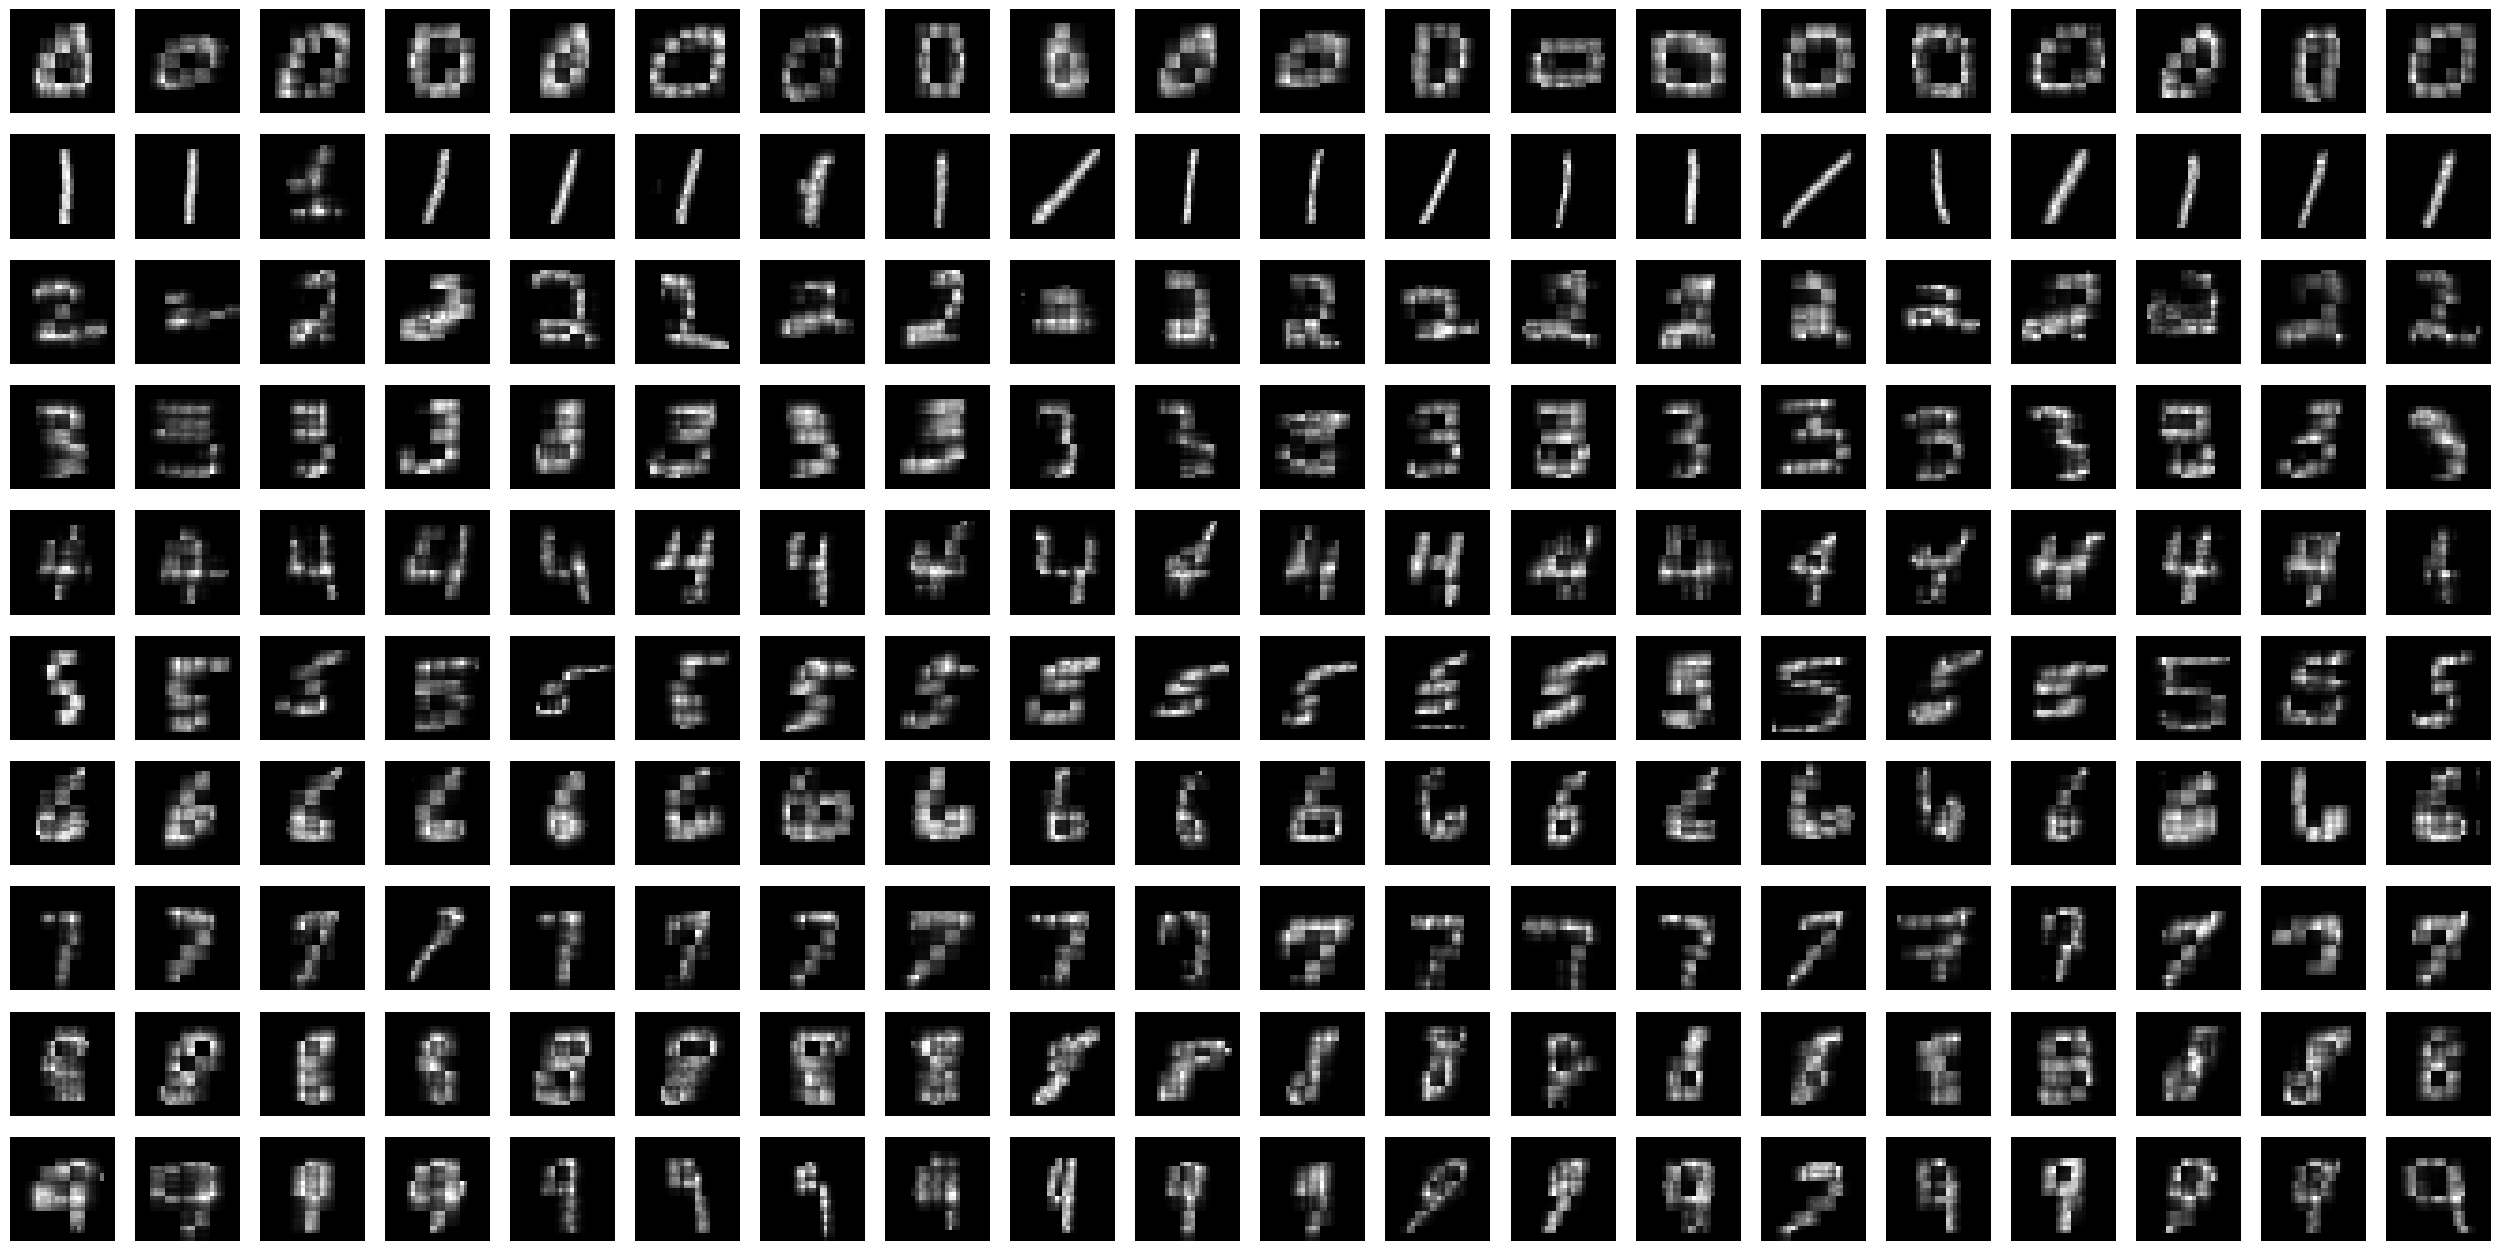

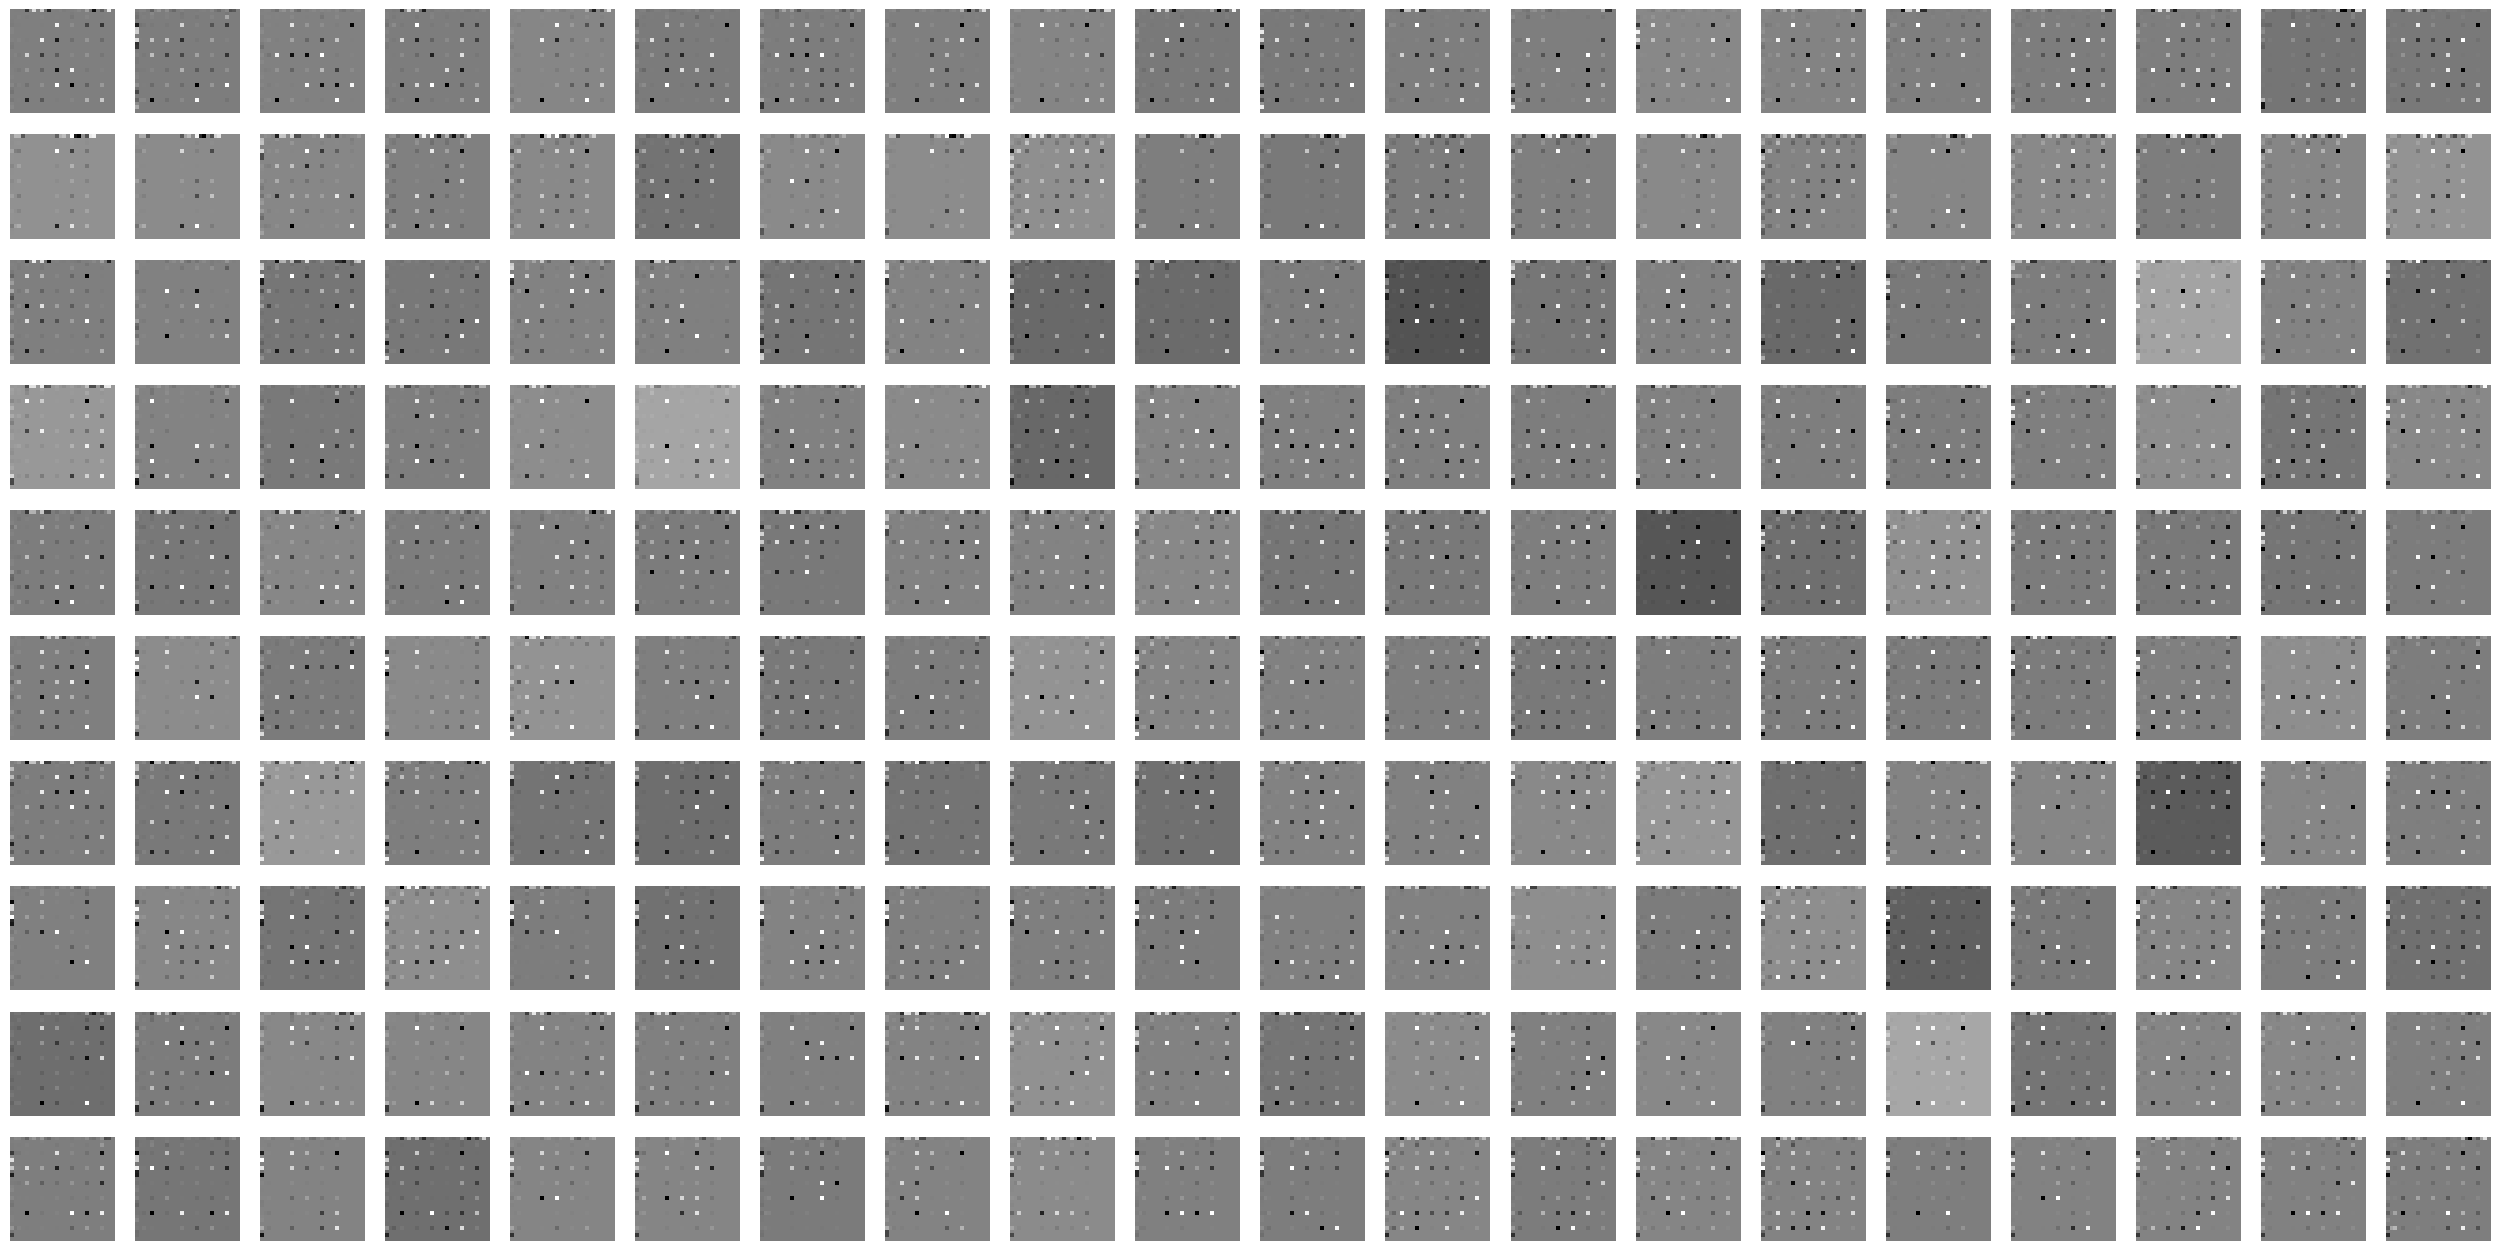

In [7]:
# Load and display images horizontally for each class
plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(renormalize_image(X_recons_digit[digit][i]).reshape((28, 28)), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.show()

plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(theta_digit[digit][i].reshape((28, 28)), cmap='gray')
        plt.axis('off')  # Hide axes

plt.show()

#### Construct Local Sub-Manifold

In [8]:
# Construct the constrained coordinates
# B_BP = ld.block_B([14, 14], [15, 15])
B_BP = ld.default_B(S, 1, cp.get_array_module(P[0]))

# Compute every datapoint's eta_hat (served as the linear constraints)
eta_hat_digit = []

for digit in range(10):
    eta_hat_list = []
    for i in range(P_digit[digit].shape[0]):
        xp = cp.get_array_module(P_digit[digit][i])
        P = (P_digit[digit][i] + eps) / scaleX_digit[digit][i]
        eta_hat = ld.get_eta(P, len(S), xp)
        eta_hat_list.append(eta_hat)

    eta_hat_digit.append(cp.asarray(eta_hat_list))

#### Fitting on Projected Points (Varying Kernel Density) and Backward Projection

Bandwidth: 0.01


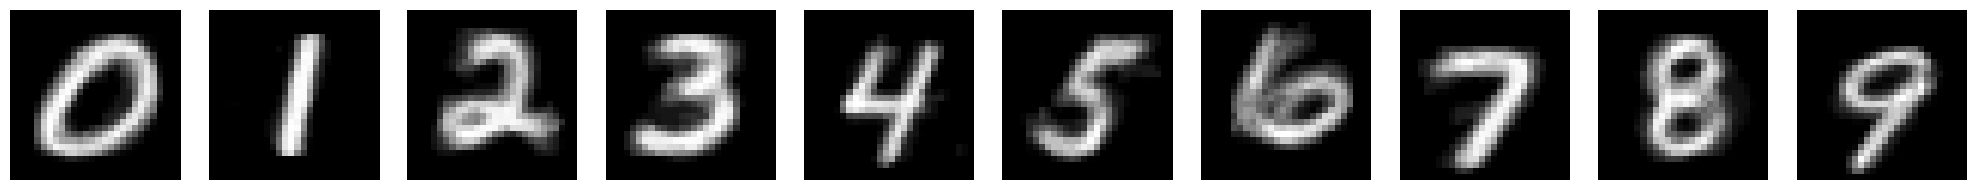

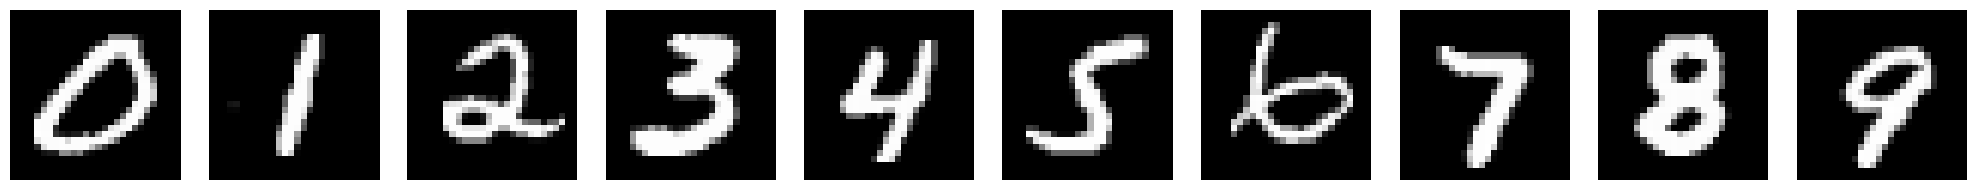

Bandwidth: 0.1


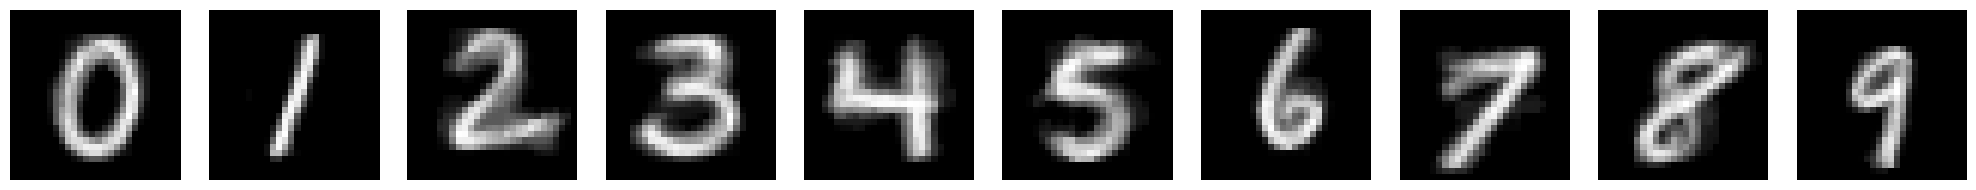

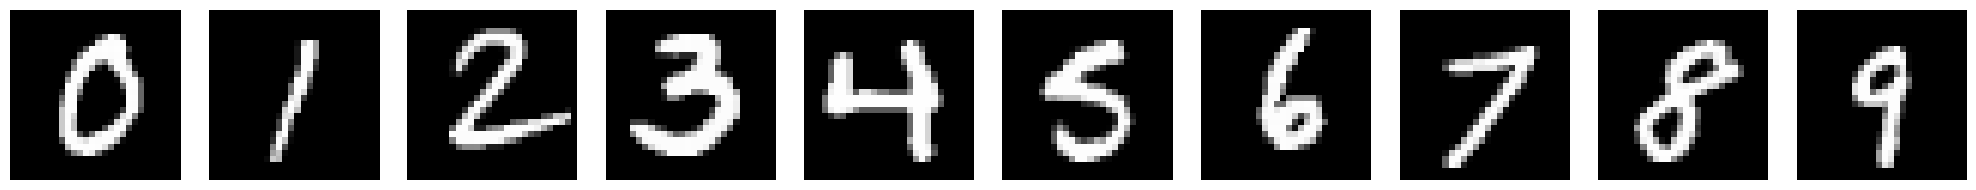

Bandwidth: 0.05


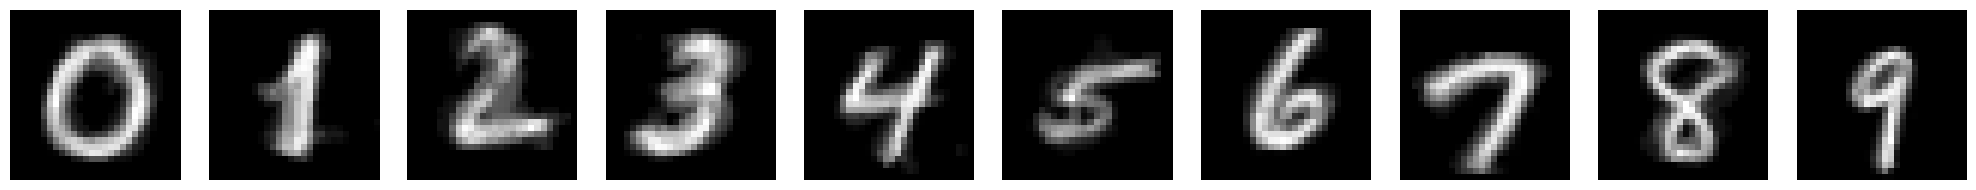

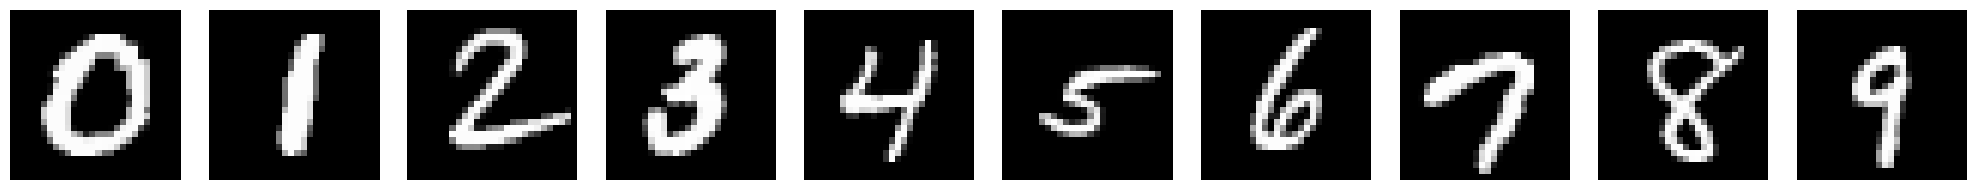

Bandwidth: 0.2


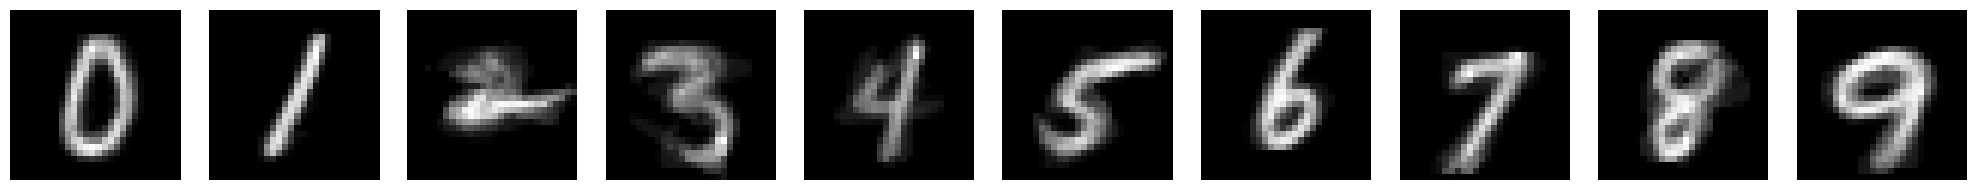

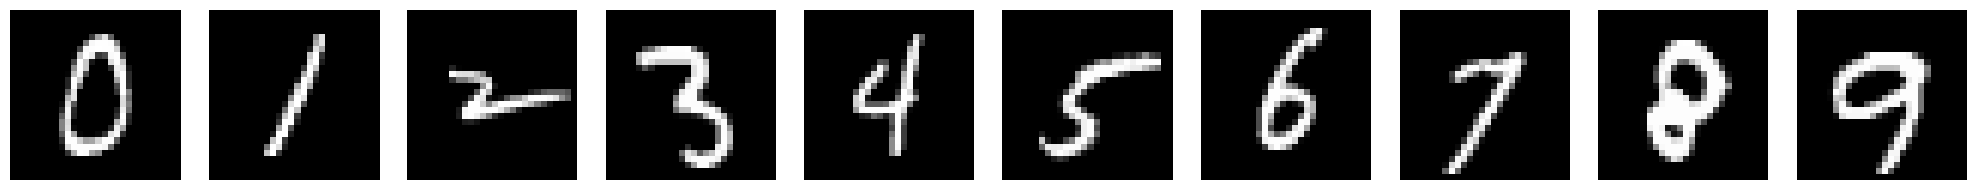

Bandwidth: 0.5


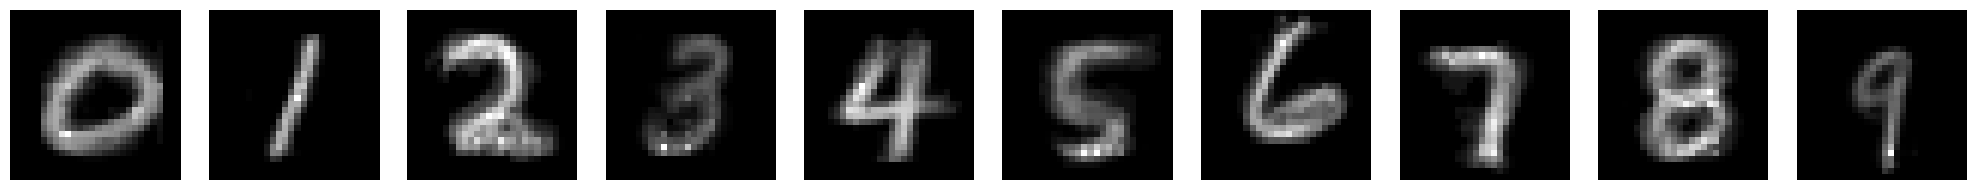

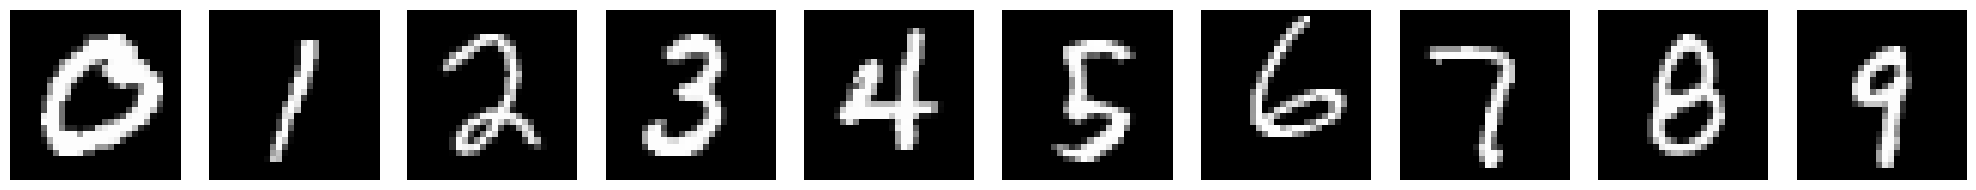

In [9]:
num_new_samples = 1

for bandwidth in [0.01, 0.1, 0.05, 0.2, 0.5]:
    print(f"Bandwidth: {bandwidth}")

    sampled_theta_digit = []
    for digit in range(10):
        reduced_theta = vectorize_tensor(theta_digit[digit], B_LD)

        # Fit a KDE to the theta values
        kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(reduced_theta)
        # Sample new data from the KDE
        sampled_reduced_theta = kde.sample(n_samples=num_new_samples)

        sampled_theta = reconstruct_tensor(sampled_reduced_theta, (num_new_samples, *S), B_LD)
        sampled_theta_digit.append(sampled_theta)

    sampled_P_BP_digit = []
    sampled_theta_BP_digit = []
    sampled_X_recons_digit = []

    for digit in range(10):
        sampled_P_BP = []
        sampled_theta_BP = []
        sampled_X_recons = []

        for i in range(paper_plot_num):
            N = ld.kNN(sampled_theta_digit[digit][i], theta_digit[digit], k=k)

            avg_scale = np.mean(scaleX_digit[digit][N])
            avg_eta_hat = np.mean(eta_hat_digit[digit][N], axis=0)

            history_kl, history_norm, P, theta = ld.BP(sampled_theta_digit[digit][i], [(P_digit[digit][j] + eps) / scaleX_digit[digit][j] for j in N], avg_eta_hat, avg_scale, B=B_BP, verbose=False, n_iter=1000, lr=1e-1)
            sampled_P_BP.append(P)
            sampled_theta_BP.append(theta)

            X_recons_ = (P).astype(np.int32)
            sampled_X_recons.append(X_recons_)

        sampled_P_BP_digit.append(np.array(sampled_P_BP))
        sampled_theta_BP_digit.append(np.array(sampled_theta_BP))
        sampled_X_recons_digit.append(np.array(sampled_X_recons))

    plt.figure(figsize=(20, 2))
    for digit in range(10):
        for i in range(paper_plot_num):
            plt.subplot(paper_plot_num, 10, digit * paper_plot_num + i + 1)
            plt.imshow(renormalize_image(sampled_X_recons_digit[digit][i]).reshape((28, 28)), cmap='gray', vmin=0, vmax=255)
            plt.axis('off')  # Hide axes

    plt.tight_layout()

    plt.savefig(f'../Figures/MNIST/extra_bandwidth/BP_bandwidth={bandwidth}.png', format='png', dpi=300)

    plt.show()

    # Find the nearest distance between every new sample among the training set in terms of norm.
    plt.figure(figsize=(20, 2))
    for digit in range(10):
        for i in range(paper_plot_num):
            norm = [np.linalg.norm(sampled_X_recons_digit[digit][i].reshape((28, 28)) - p.reshape((28, 28))) for p in P_digit[digit]]
            idx = np.argmin(norm)
            plt.subplot(paper_plot_num, 10, digit * paper_plot_num + i + 1)
            plt.imshow(P_digit[digit][idx].reshape((28, 28)), cmap='gray', vmin=0, vmax=255) # [0, 255]
            plt.axis('off')  # Hide axes

    plt.tight_layout()

    plt.savefig(f'../Figures/MNIST/extra_bandwidth/BP_bandwidth={bandwidth}_compare.png', format='png', dpi=300)

    plt.show()